In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from datetime import datetime
from tqdm import tqdm
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

from core.multimodal.dataset2 import VPSMDatasetV2
from core.multimodal.model import ModelV1

In [2]:
def get_config(random_seed):
    config = {
        'project': 'multimodal-contrastive',
        'random_seed': random_seed,
        'use_wandb': True,
        'save_weights': True,
        'weights_path': f'/home/mariia/AstroML/weights/{datetime.now().strftime("%Y-%m-%d-%H-%M")}',
        'use_pretrain': None,

        # Data General
        'dataset': 'VPSMDatasetV2',     # 'VPSMDataset' or 'VPSMDatasetV2'
        'data_root': '/home/mariia/AstroML/data/asassn/',
        'file': 'preprocessed_data/full/spectra_and_v',
        'classes': None,
        'min_samples': 200,
        'max_samples': None,

        # Photometry
        'v_zip': 'asassnvarlc_vband_complete.zip',
        'v_prefix': 'vardb_files',
        'seq_len': 200,
        'phased': True,
        'clip': False,
        'aux': True,

        # Spectra
        'lamost_spec_dir': 'Spectra/v2',
        'spectra_v_file': 'spectra_v_merged.csv',
        'z_corr': False,

        # Photometry Model
        'p_encoder_layers': 8,
        'p_d_model': 128,
        'p_dropout': 0,
        'p_feature_size': 3,
        'p_n_heads': 4,
        'p_d_ff': 512,

        # Spectra Model
        's_hidden_dim': 512,
        's_dropout': 0,

        # Metadata Model
        'm_hidden_dim': 512,
        'm_dropout': 0,

        # MultiModal Model
        'model': 'ModelV1',     # 'ModelV0' or 'ModelV1'
        'hidden_dim': 256,

        # Training
        'batch_size': 32,
        'lr': 1e-3,
        'weight_decay': 0,
        'epochs': 50,
        'optimizer': 'AdamW',
        'early_stopping_patience': 100,

        # Learning Rate Scheduler
        'factor': 0.3,
        'patience': 50,
    }

    config['p_feature_size'] += 4

    return config

In [3]:
config = get_config(42)
CLASSES = ['EW', 'SR', 'EA', 'RRAB', 'EB', 'ROT', 'RRC', 'HADS', 'M', 'DSCT']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_dataset = VPSMDatasetV2(split='train', classes=CLASSES, seq_len=200, phased=True, clip=False, aux=True, z_corr=False, random_seed=42)
val_dataset = VPSMDatasetV2(split='val', classes=CLASSES, seq_len=200, phased=True, clip=False, aux=True, z_corr=False, random_seed=42)
test_dataset = VPSMDatasetV2(split='test', classes=CLASSES, seq_len=200, phased=True, clip=False, aux=True, z_corr=False, random_seed=42)

In [43]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [19]:
class ClassificationModelv0(nn.Module):
    def __init__(self, config, num_classes, freeze=False, weights_path=None):
        super(ClassificationModelv0, self).__init__()

        self.encoder = ModelV1(config)
        self.encoder = self.encoder.to(device)

        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if weights_path:
            self.encoder.load_state_dict(torch.load(weights_path))

        self.fc = nn.Linear(768, num_classes)

    def forward(self, photometry, photometry_mask, spectra, metadata):
        p_emb, s_emb, m_emb = self.encoder.get_embeddings(photometry, photometry_mask, spectra, metadata)
        emb = torch.cat((p_emb, s_emb, m_emb), dim=1)
        logits = self.fc(emb)

        return logits

In [24]:
class ClassificationModelv1(nn.Module):
    def __init__(self, config, num_classes, freeze=False, weights_path=None):
        super(ClassificationModelv1, self).__init__()

        self.encoder = ModelV1(config)
        self.encoder = self.encoder.to(device)

        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if weights_path:
            self.encoder.load_state_dict(torch.load(weights_path))

        self.mlp = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, photometry, photometry_mask, spectra, metadata):
        p_emb, s_emb, m_emb = self.encoder.get_embeddings(photometry, photometry_mask, spectra, metadata)
        emb = torch.cat((p_emb, s_emb, m_emb), dim=1)
        logits = self.mlp(emb)

        return logits

In [77]:
class ClassificationModelv2(nn.Module):
    def __init__(self, config, num_classes, freeze=False, weights_path=None):
        super(ClassificationModelv2, self).__init__()

        self.encoder = ModelV1(config)
        self.encoder = self.encoder.to(device)

        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        if weights_path:
            self.encoder.load_state_dict(torch.load(weights_path))

        self.mlp = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, photometry, photometry_mask, spectra, metadata):
        p_emb, s_emb, m_emb = self.encoder.get_embeddings(photometry, photometry_mask, spectra, metadata)
        emb = torch.cat((p_emb, s_emb, m_emb), dim=1)
        logits = self.mlp(emb)

        return logits

In [ ]:
def train_epoch(model):
    model.train()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for photometry, photometry_mask, spectra, metadata, y in tqdm(train_dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata, y = spectra.to(device), metadata.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(photometry, photometry_mask, spectra, metadata)
        loss = criterion(logits, y)
        total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == y).sum().item()

        total_correct_predictions += correct_predictions
        total_predictions += y.size(0)

        loss.backward()
        optimizer.step()
        
    print(f'Train Loss: {sum(total_loss) / len(total_loss)} Acc: {total_correct_predictions / total_predictions}')

In [ ]:
def val_epoch(model):
    model.eval()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for photometry, photometry_mask, spectra, metadata, y in tqdm(val_dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata, y = spectra.to(device), metadata.to(device), y.to(device)

        with torch.no_grad():
            logits = model(photometry, photometry_mask, spectra, metadata)
            loss = criterion(logits, y)
            total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == y).sum().item()

        total_correct_predictions += correct_predictions
        total_predictions += y.size(0)

    print(f'Val Loss: {sum(total_loss) / len(total_loss)} Acc: {total_correct_predictions / total_predictions}')

In [68]:
def evaluate(model, val_dataloader):
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    for photometry, photometry_mask, spectra, metadata, y in tqdm(val_dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)

        with torch.no_grad():
            logits = model(photometry, photometry_mask, spectra, metadata)
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)

            all_true_labels.extend(y.numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    acc = sum([1 if all_true_labels[i] == all_predicted_labels[i] else 0 for i in range(len(all_true_labels))]) / len(all_true_labels)
    print(f'Total Accuracy: {round(acc * 100, 2)}%')

    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
    conf_matrix_percent = 100 * conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    avg_acc = sum([conf_matrix_percent[i][i] for i in range(len(conf_matrix_percent))]) / len(conf_matrix_percent)
    print(f'Avarage Accuracy: {round(avg_acc, 2)}%')
    
    labels = [val_dataset.id2target[i] for i in range(len(conf_matrix))]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix - Absolute Values')

    sns.heatmap(conf_matrix_percent, annot=True, fmt='.0f', cmap='Blues', xticklabels=labels, yticklabels=labels,
                ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix - Percentages')

In [14]:
model2 = ClassificationModelv0(config, train_dataset.num_classes, freeze=False, weights_path=None)
model2 = model2.to(device)
optimizer = Adam(model2.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model2)
    val_epoch(model2)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.47it/s]


Train Loss: 0.6386939424883437, 0.8125036179450073


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


Val Loss: 0.47850486921036944, 0.824367816091954
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.41it/s]


Train Loss: 0.3620617736268927, 0.8808683068017367


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


Val Loss: 0.31699184583061757, 0.879080459770115
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:08<00:00,  7.93it/s]


Train Loss: 0.2949666465184203, 0.8988133140376267


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.41it/s]


Val Loss: 0.29675004082759293, 0.8983908045977012
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.39it/s]


Train Loss: 0.26778928455379275, 0.9082489146164978


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


Val Loss: 0.2709609578596428, 0.9052873563218391
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.43it/s]


Train Loss: 0.24540261610376615, 0.912821997105644


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.44it/s]

Val Loss: 0.25600453284021246, 0.9048275862068965


In [21]:
model3 = ClassificationModelv0(config, train_dataset.num_classes, freeze=False, weights_path='/home/mariia/AstroML/weights/2024-06-13-18-41-lwvpa5fm/weights-49.pth')
model3 = model3.to(device)
optimizer = Adam(model3.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model3)
    val_epoch(model3)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.41it/s]


Train Loss: 0.44794312120863683, 0.8915774240231549


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


Val Loss: 0.24785694359418223, 0.9177011494252874
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:05<00:00,  8.22it/s]


Train Loss: 0.19215959946245506, 0.9375397973950796


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]


Val Loss: 0.18002090646255323, 0.9406896551724138
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.33it/s]


Train Loss: 0.1669325926668804, 0.9426917510853835


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.40it/s]


Val Loss: 0.18054914054022553, 0.9351724137931035
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:08<00:00,  7.86it/s]


Train Loss: 0.15330873863012703, 0.9460492040520984


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


Val Loss: 0.18708774174549891, 0.9314942528735632
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:08<00:00,  7.91it/s]


Train Loss: 0.1492605349773334, 0.9448335745296671


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.36it/s]

Val Loss: 0.23837091706638389, 0.9163218390804597


In [22]:
model4 = ClassificationModelv0(config, train_dataset.num_classes, freeze=True, weights_path='/home/mariia/AstroML/weights/2024-06-13-18-41-lwvpa5fm/weights-49.pth')
model4 = model4.to(device)
optimizer = Adam(model4.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model4)
    val_epoch(model4)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.47it/s]


Train Loss: 0.9310294934444957, 0.8226917510853835


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.45it/s]


Val Loss: 0.48672361573313966, 0.8910344827586207
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:00<00:00,  8.87it/s]


Train Loss: 0.37739977709673067, 0.908712011577424


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.40it/s]


Val Loss: 0.33144965099499507, 0.9131034482758621
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:01<00:00,  8.73it/s]


Train Loss: 0.28811167340587684, 0.9213314037626628


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


Val Loss: 0.27919103807824497, 0.9250574712643678
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.59it/s]


Train Loss: 0.25215052080651124, 0.9264254703328509


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.25it/s]


Val Loss: 0.2531182610238081, 0.926896551724138
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.37it/s]


Train Loss: 0.23290637006500253, 0.9305933429811867


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.48it/s]

Val Loss: 0.2380614610224524, 0.9291954022988506


In [25]:
model5 = ClassificationModelv1(config, train_dataset.num_classes, freeze=False, weights_path=None)
model5 = model5.to(device)
optimizer = Adam(model5.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model5)
    val_epoch(model5)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:08<00:00,  7.88it/s]


Train Loss: 0.5706704044231662, 0.8100144717800289


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.32it/s]


Val Loss: 0.33402625385069235, 0.8809195402298851
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.35it/s]


Train Loss: 0.32121289840175044, 0.8867727930535456


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.45it/s]


Val Loss: 0.29631888381588983, 0.8850574712643678
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:05<00:00,  8.24it/s]


Train Loss: 0.27758986088274806, 0.8999131693198263


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.24it/s]


Val Loss: 0.28003239812610176, 0.8983908045977012
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.37it/s]


Train Loss: 0.2576560329921819, 0.9047178002894356


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.50it/s]


Val Loss: 0.30254317102405953, 0.8855172413793103
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.43it/s]


Train Loss: 0.24313515820023085, 0.910506512301013


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.27it/s]

Val Loss: 0.254395226475454, 0.9052873563218391


In [35]:
model6 = ClassificationModelv1(config, train_dataset.num_classes, freeze=False, weights_path='/home/mariia/AstroML/weights/2024-06-13-18-41-lwvpa5fm/weights-49.pth')
model6 = model6.to(device)
optimizer = Adam(model6.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model6)
    val_epoch(model6)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:05<00:00,  8.25it/s]


Train Loss: 0.35545789309673836, 0.8927351664254704


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.21it/s]


Val Loss: 0.19588401003548986, 0.927816091954023
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:01<00:00,  8.72it/s]


Train Loss: 0.1867073287325049, 0.9348191027496382


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]


Val Loss: 0.18883509892518358, 0.9305747126436782
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.45it/s]


Train Loss: 0.1695578672785174, 0.9391606367583213


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


Val Loss: 0.18468517153729302, 0.9319540229885057
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.58it/s]


Train Loss: 0.1678055792943471, 0.9383502170767004


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.51it/s]


Val Loss: 0.1902554904603783, 0.9314942528735632
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.54it/s]


Train Loss: 0.1429450206988905, 0.9455861070911722


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]

Val Loss: 0.18423148982230272, 0.9434482758620689


In [36]:
model7 = ClassificationModelv1(config, train_dataset.num_classes, freeze=True, weights_path='/home/mariia/AstroML/weights/2024-06-13-18-41-lwvpa5fm/weights-49.pth')
model7 = model7.to(device)
optimizer = Adam(model7.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model7)
    val_epoch(model7)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:00<00:00,  8.88it/s]


Train Loss: 0.44141474591085206, 0.8792474674384949


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.51it/s]


Val Loss: 0.2230767992681221, 0.9305747126436782
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.59it/s]


Train Loss: 0.19654278686891, 0.9336034732272069


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.38it/s]


Val Loss: 0.20407174394794686, 0.9314942528735632
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.63it/s]


Train Loss: 0.17596997884619567, 0.9389290882778581


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.39it/s]


Val Loss: 0.1784633427433779, 0.9379310344827586
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:01<00:00,  8.76it/s]


Train Loss: 0.1662501562335011, 0.9417655571635312


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.37it/s]


Val Loss: 0.17474022977095208, 0.9402298850574713
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:00<00:00,  8.93it/s]


Train Loss: 0.15736992196352392, 0.9437337192474674


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]

Val Loss: 0.17145138660442386, 0.9425287356321839


In [78]:
model8 = ClassificationModelv2(config, train_dataset.num_classes, freeze=False, weights_path=None)
model8 = model8.to(device)
optimizer = Adam(model8.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model8)
    val_epoch(model8)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.40it/s]


Train Loss: 0.6256422782937686, 0.7890014471780029


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.32it/s]


Val Loss: 0.35813762024318907, 0.8795402298850574
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:05<00:00,  8.28it/s]


Train Loss: 0.3279280334573101, 0.8834732272069464


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.38it/s]


Val Loss: 0.33823380364543376, 0.888735632183908
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:06<00:00,  8.15it/s]


Train Loss: 0.2868023492809799, 0.8969609261939219


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.43it/s]


Val Loss: 0.27973264687598737, 0.9011494252873563
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.35it/s]


Train Loss: 0.2647633174986199, 0.9032127351664254


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.24it/s]


Val Loss: 0.2952179355077747, 0.8910344827586207
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.52it/s]


Train Loss: 0.2518056286636878, 0.906685962373372


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.49it/s]

Val Loss: 0.2733854796165628, 0.9002298850574713


In [79]:
model9 = ClassificationModelv2(config, train_dataset.num_classes, freeze=False, weights_path='/home/mariia/AstroML/weights/2024-06-13-18-41-lwvpa5fm/weights-49.pth')
model9 = model9.to(device)
optimizer = Adam(model9.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model9)
    val_epoch(model9)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.34it/s]


Train Loss: 0.3593915928776065, 0.8835311143270622


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


Val Loss: 0.19477570081225543, 0.9328735632183908
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.53it/s]


Train Loss: 0.1816939810394413, 0.9355137481910275


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.42it/s]


Val Loss: 0.2122569960398216, 0.9167816091954023
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.52it/s]


Train Loss: 0.16193903174803212, 0.9439073806078148


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.32it/s]


Val Loss: 0.18654434649643542, 0.9360919540229885
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.50it/s]


Train Loss: 0.15649634583646224, 0.9437337192474674


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


Val Loss: 0.20127783303820146, 0.9328735632183908
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:08<00:00,  7.90it/s]


Train Loss: 0.14929261944963837, 0.9459913169319827


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]

Val Loss: 0.18160903570927023, 0.9324137931034483


In [80]:
model10 = ClassificationModelv2(config, train_dataset.num_classes, freeze=True, weights_path='/home/mariia/AstroML/weights/2024-06-13-18-41-lwvpa5fm/weights-49.pth')
model10 = model10.to(device)
optimizer = Adam(model10.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.CrossEntropyLoss()

for i in range(5):
    print(f'Epoch {i}')
    train_epoch(model10)
    val_epoch(model10)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:10<00:00,  7.61it/s]


Train Loss: 0.3895578891383829, 0.8856150506512301


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:32<00:00,  2.11it/s]


Val Loss: 0.19733673432047533, 0.9356321839080459
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.43it/s]


Train Loss: 0.18768637511465286, 0.9347033285094066


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.42it/s]


Val Loss: 0.18341607196934467, 0.9328735632183908
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.64it/s]


Train Loss: 0.1668998629303166, 0.9407814761215629


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.43it/s]


Val Loss: 0.16174613536842278, 0.9434482758620689
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:01<00:00,  8.84it/s]


Train Loss: 0.15624833850845418, 0.9439073806078148


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.40it/s]


Val Loss: 0.1655793269336059, 0.9411494252873563
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:00<00:00,  8.98it/s]


Train Loss: 0.14746010845302845, 0.9470911722141824


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.50it/s]

Val Loss: 0.1682211342276252, 0.9374712643678161


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:26<00:00,  2.56it/s]


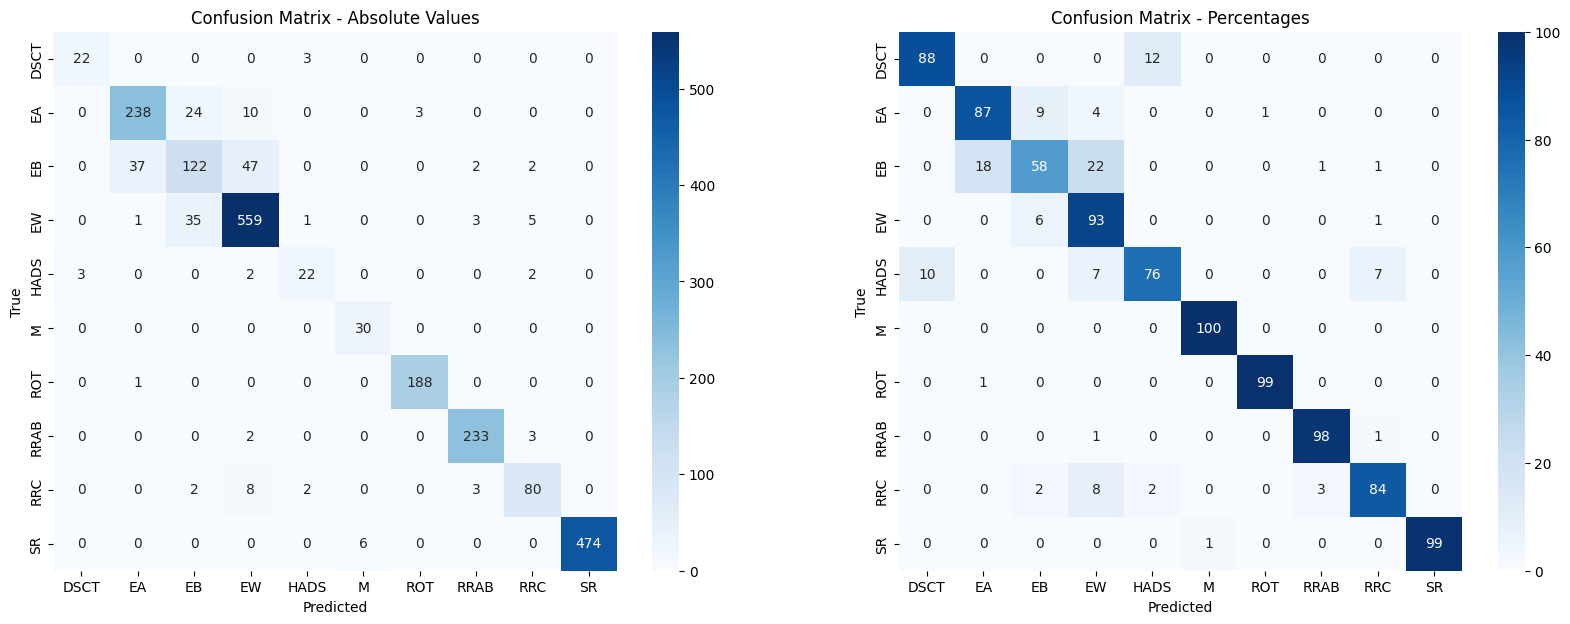

In [37]:
evaluate(model2, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:26<00:00,  2.58it/s]


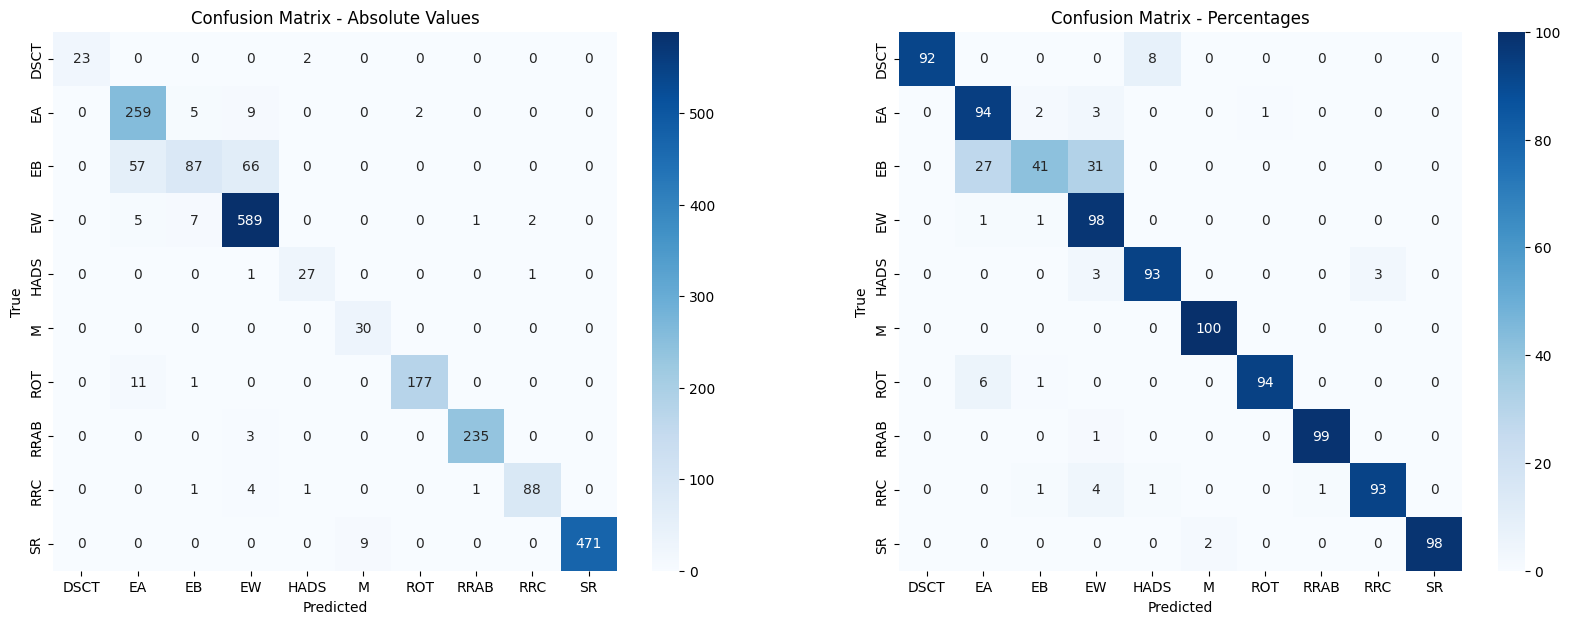

In [38]:
evaluate(model3, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:25<00:00,  2.65it/s]


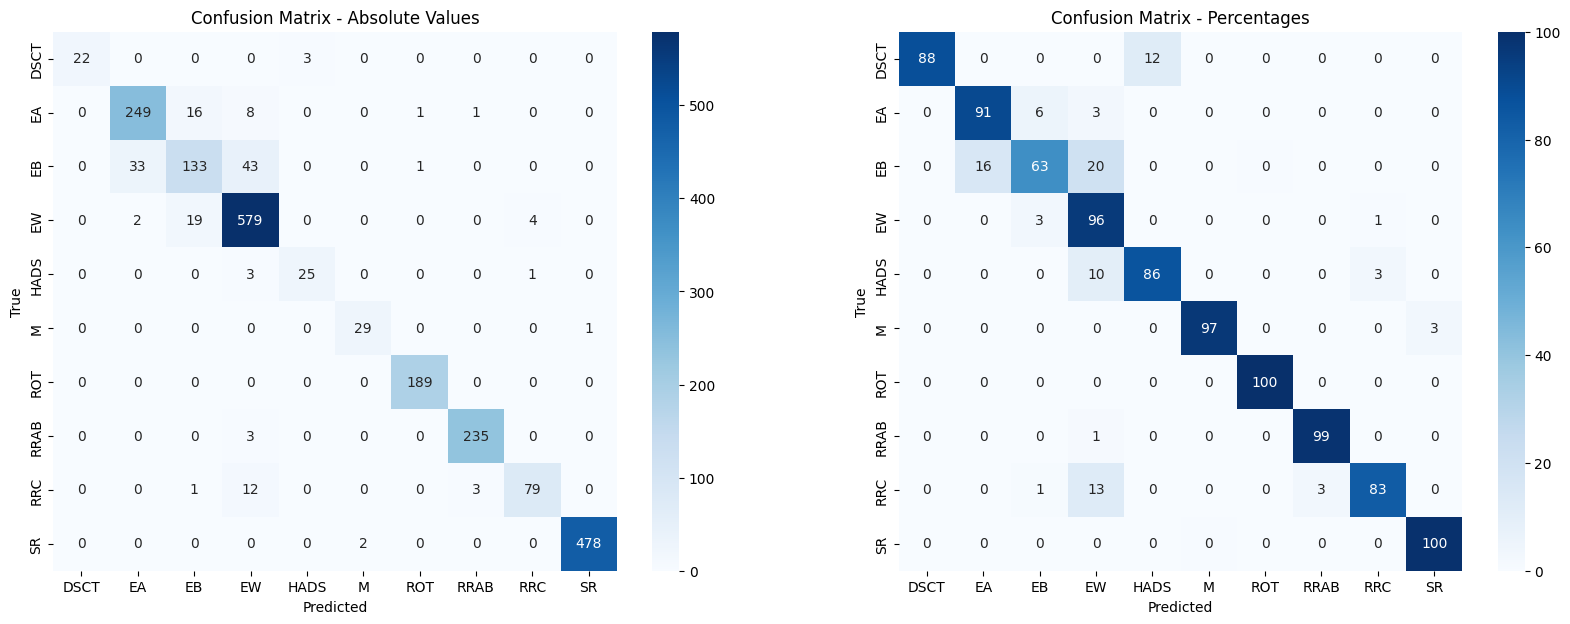

In [39]:
evaluate(model4, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:26<00:00,  2.56it/s]


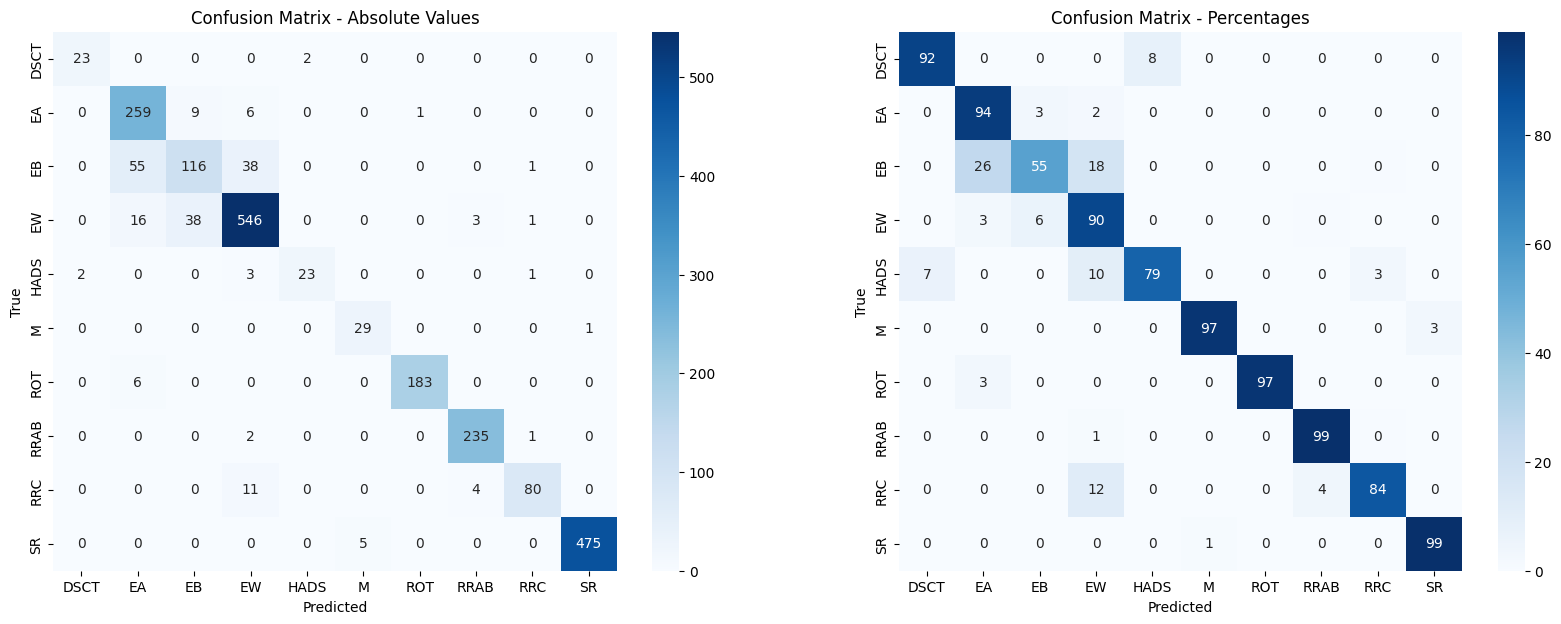

In [40]:
evaluate(model5, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:26<00:00,  2.59it/s]


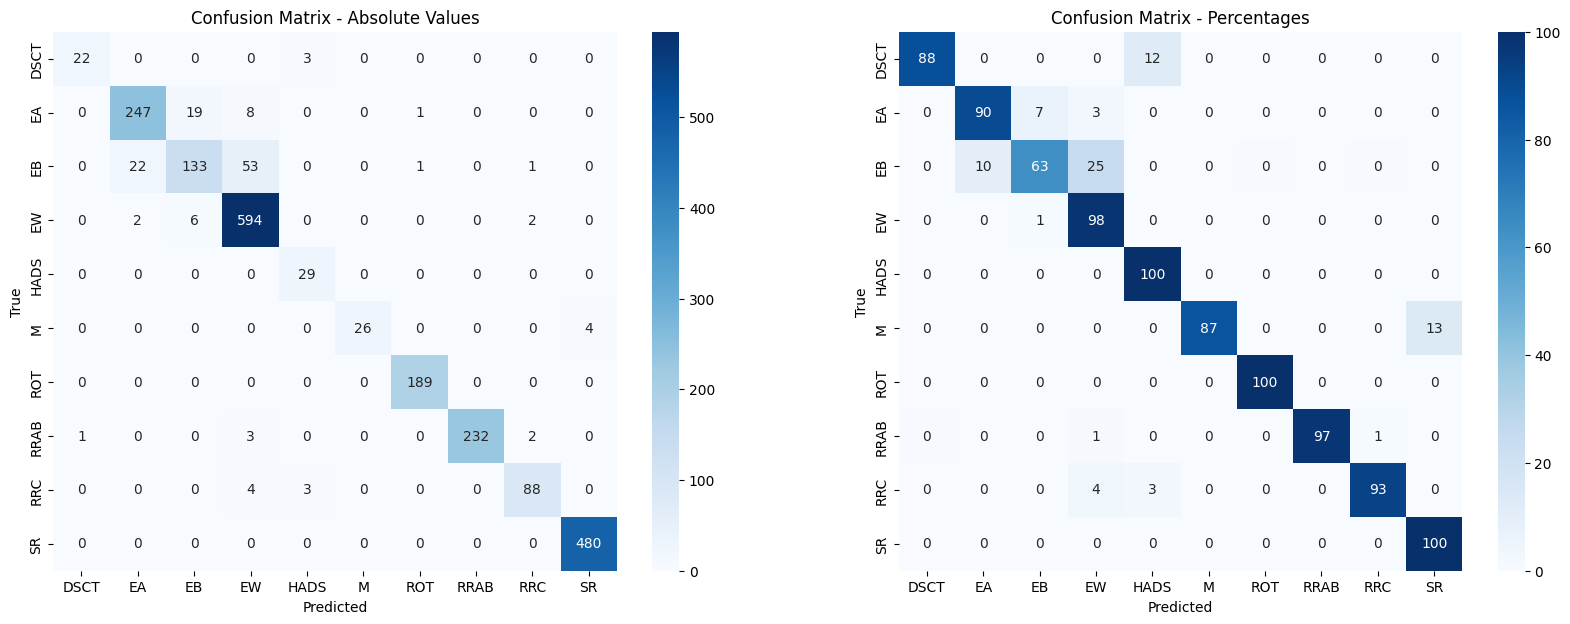

In [41]:
evaluate(model6, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:26<00:00,  2.59it/s]


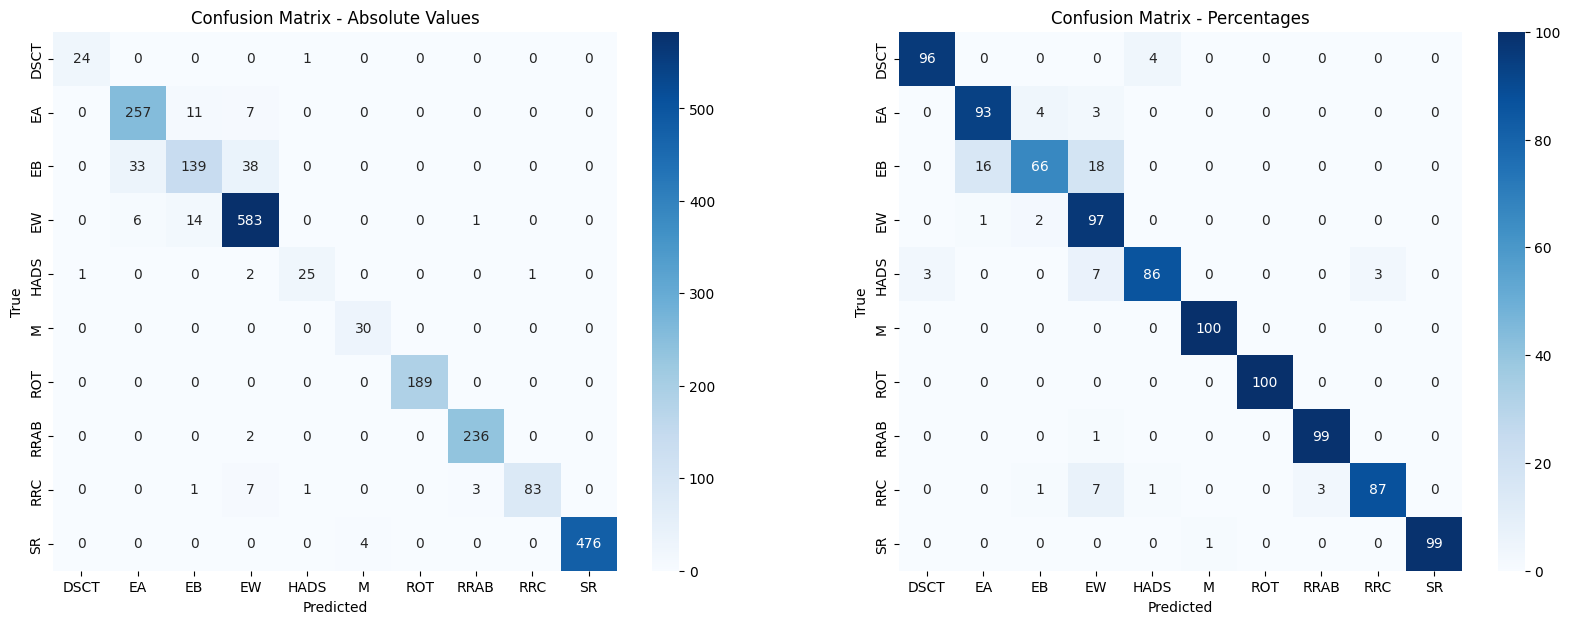

In [42]:
evaluate(model7, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:26<00:00,  2.54it/s]


Total Accuracy: 90.02%
Avarage Accuracy: 88.36%


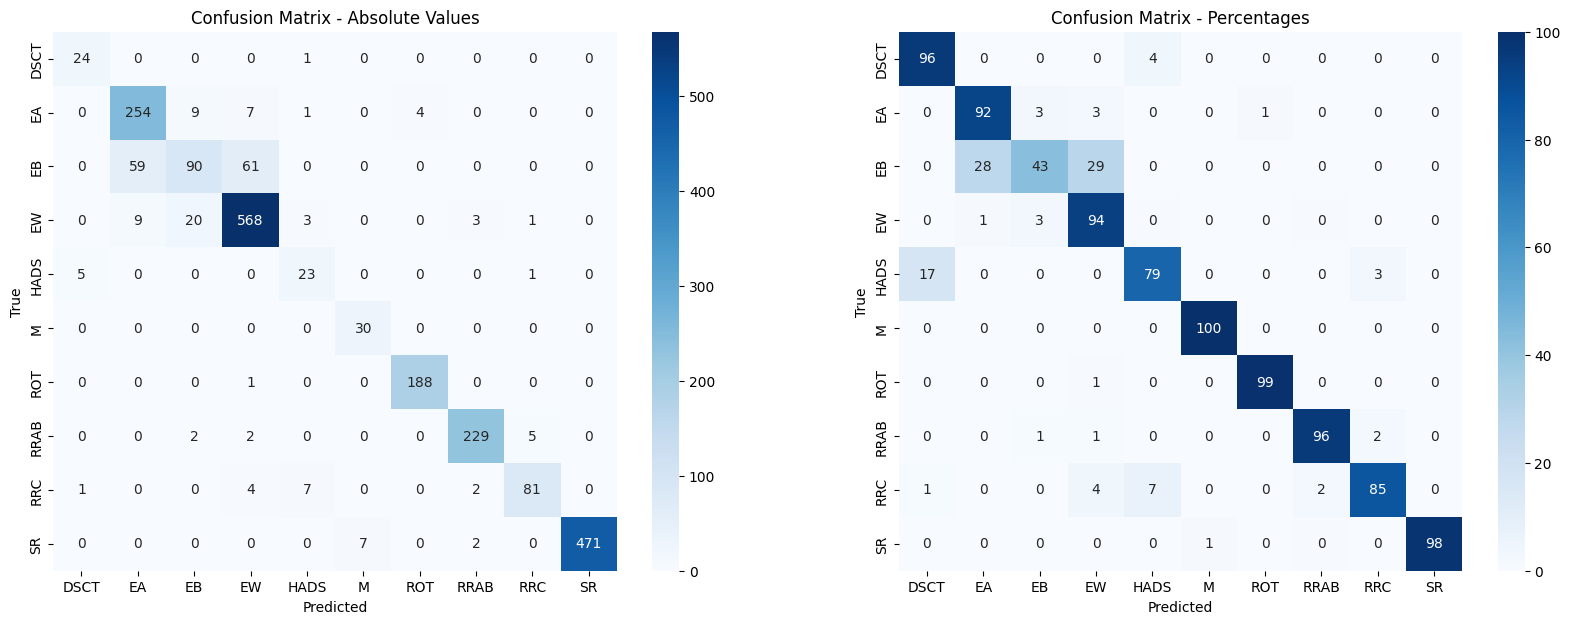

In [81]:
evaluate(model8, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:26<00:00,  2.57it/s]


Total Accuracy: 92.97%
Avarage Accuracy: 91.76%


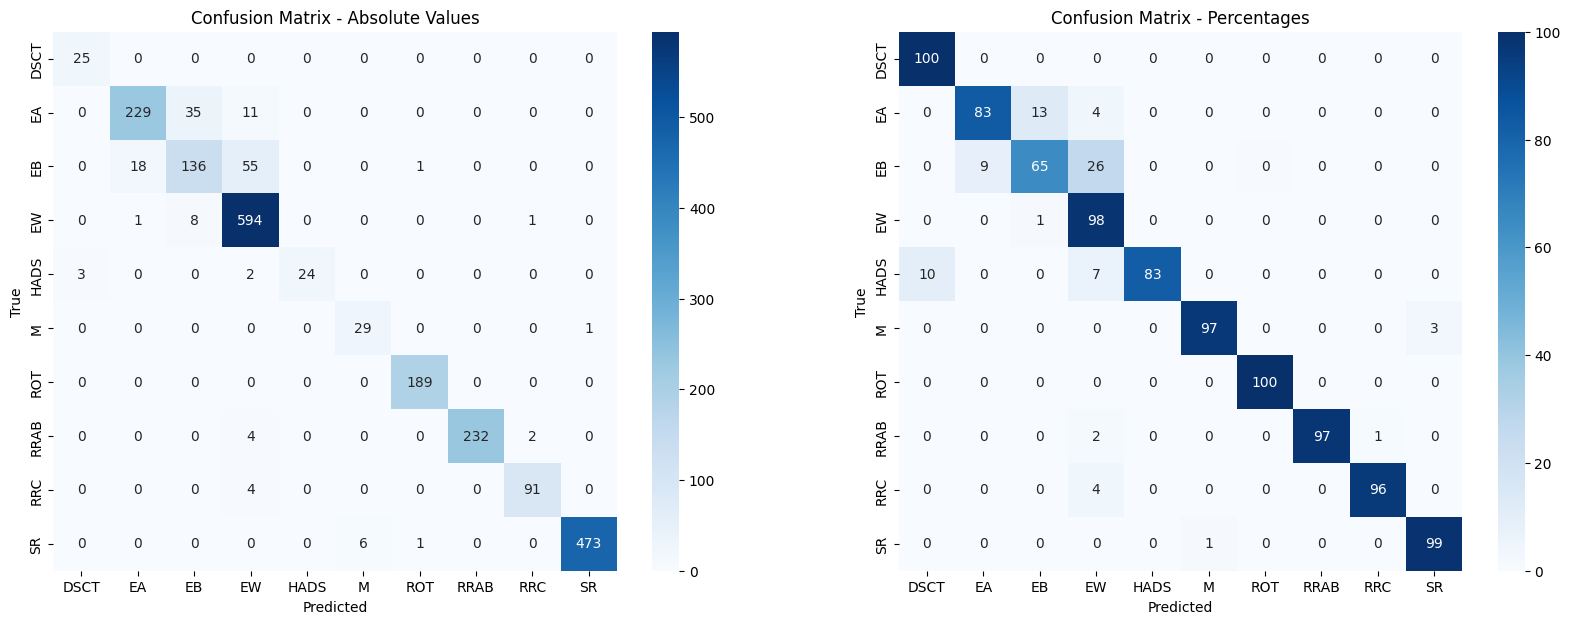

In [82]:
evaluate(model9, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]


Total Accuracy: 93.89%
Avarage Accuracy: 92.4%


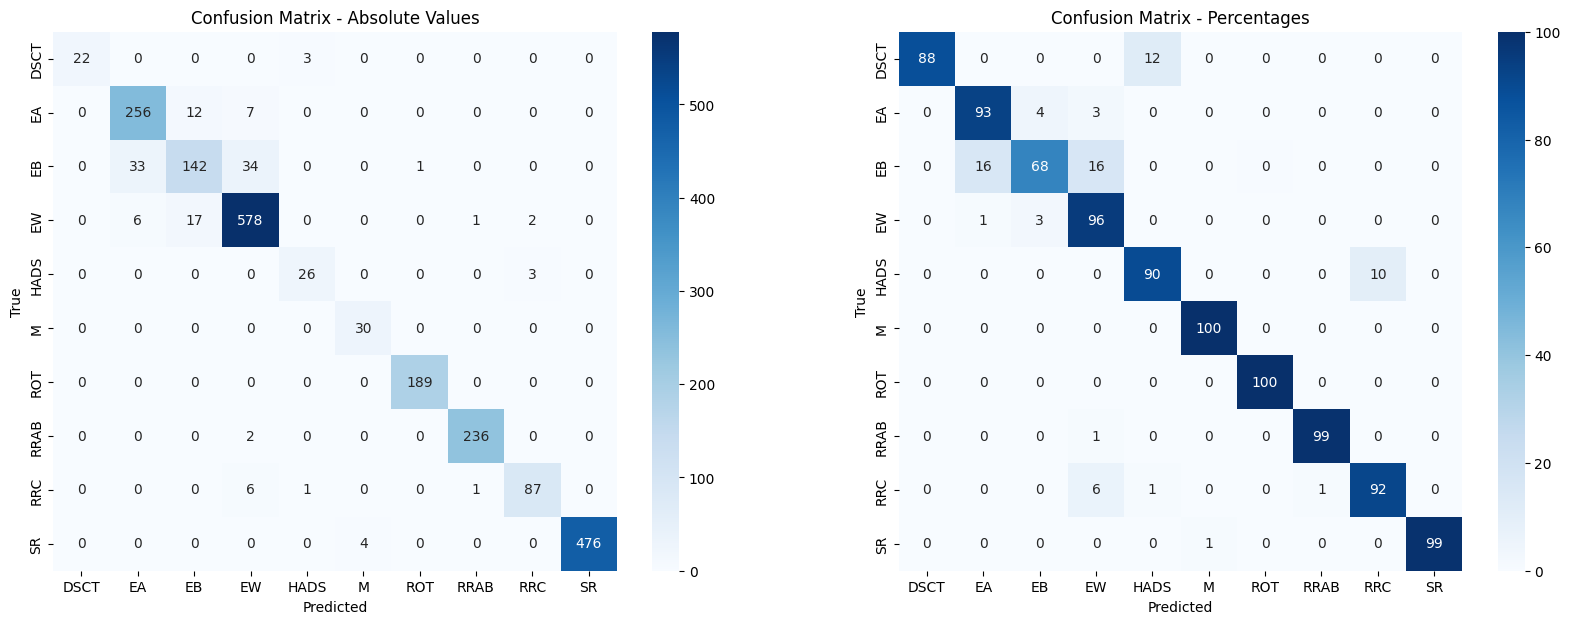

In [83]:
evaluate(model10, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:49<00:00,  1.43it/s]


Total Accuracy: 91.46%
Avarage Accuracy: 91.22%


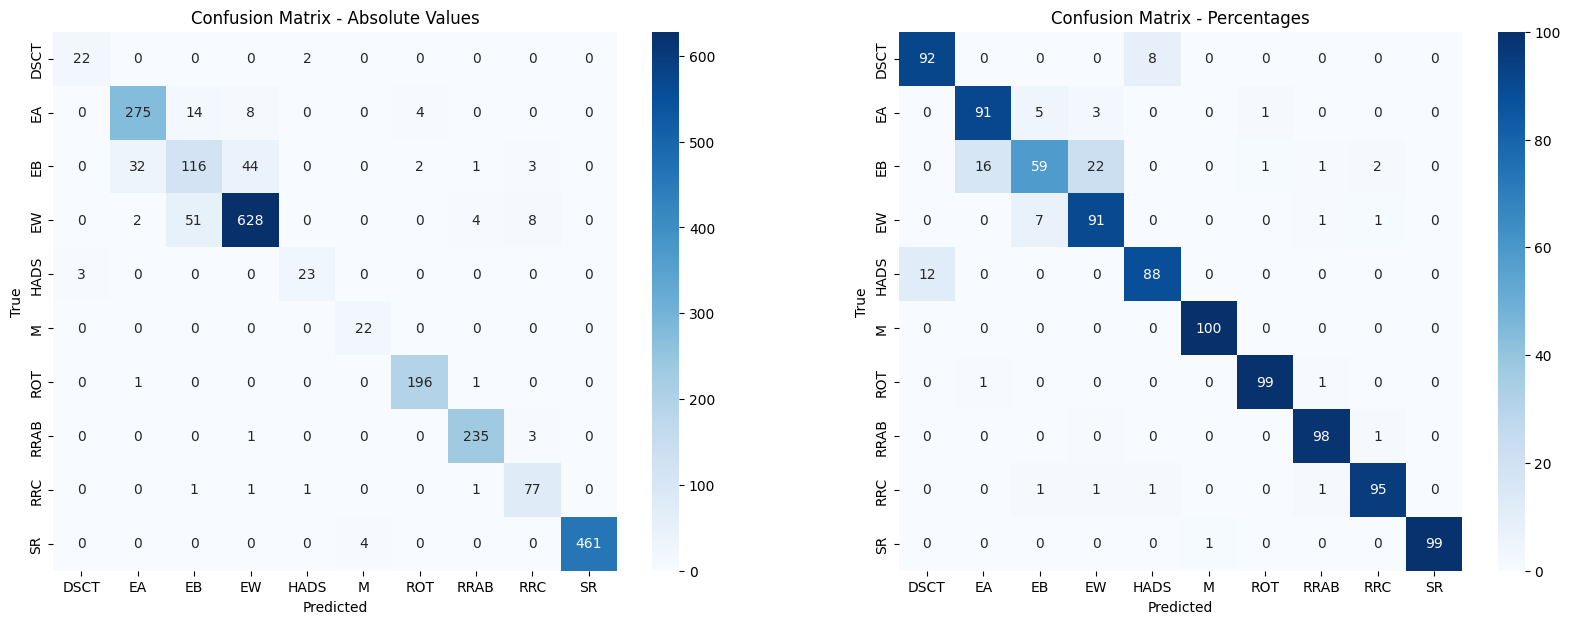

In [69]:
evaluate(model2, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:23<00:00,  2.97it/s]


Total Accuracy: 92.52%
Avarage Accuracy: 90.7%


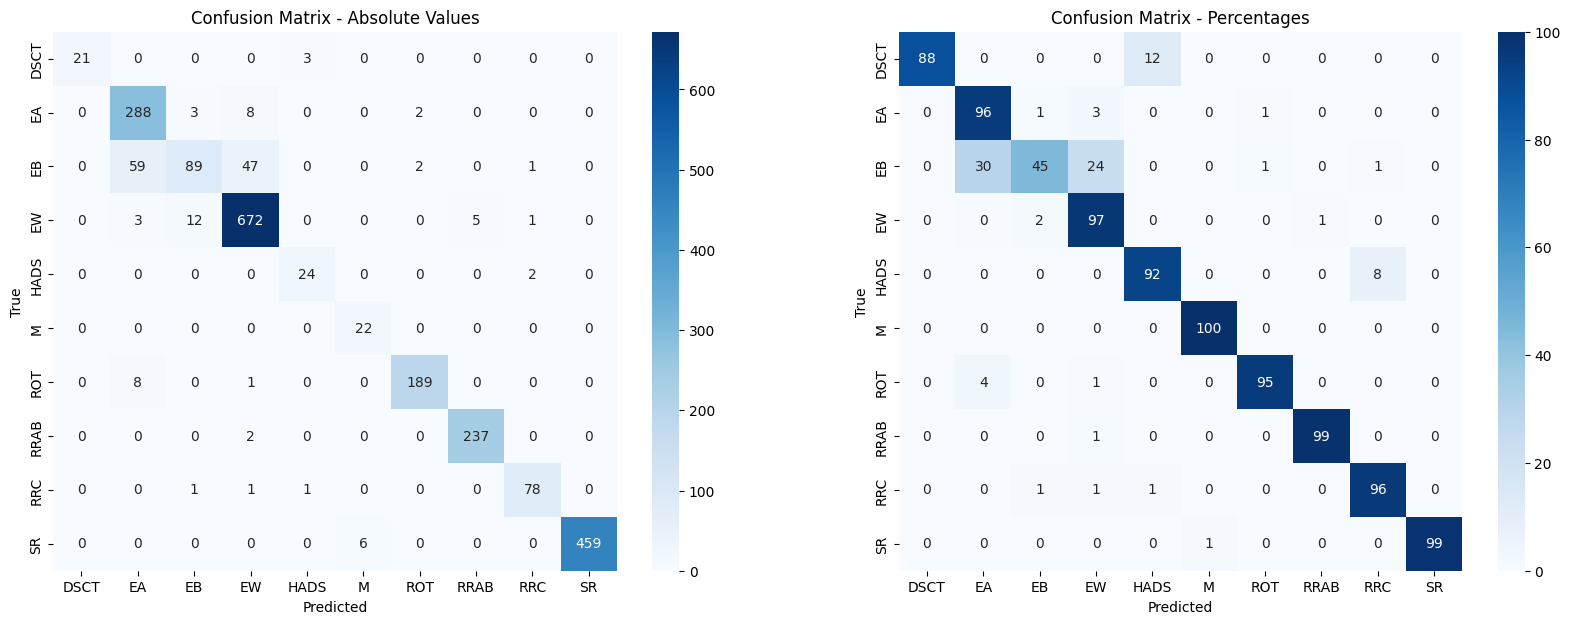

In [70]:
evaluate(model3, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:24<00:00,  2.96it/s]


Total Accuracy: 92.88%
Avarage Accuracy: 91.85%


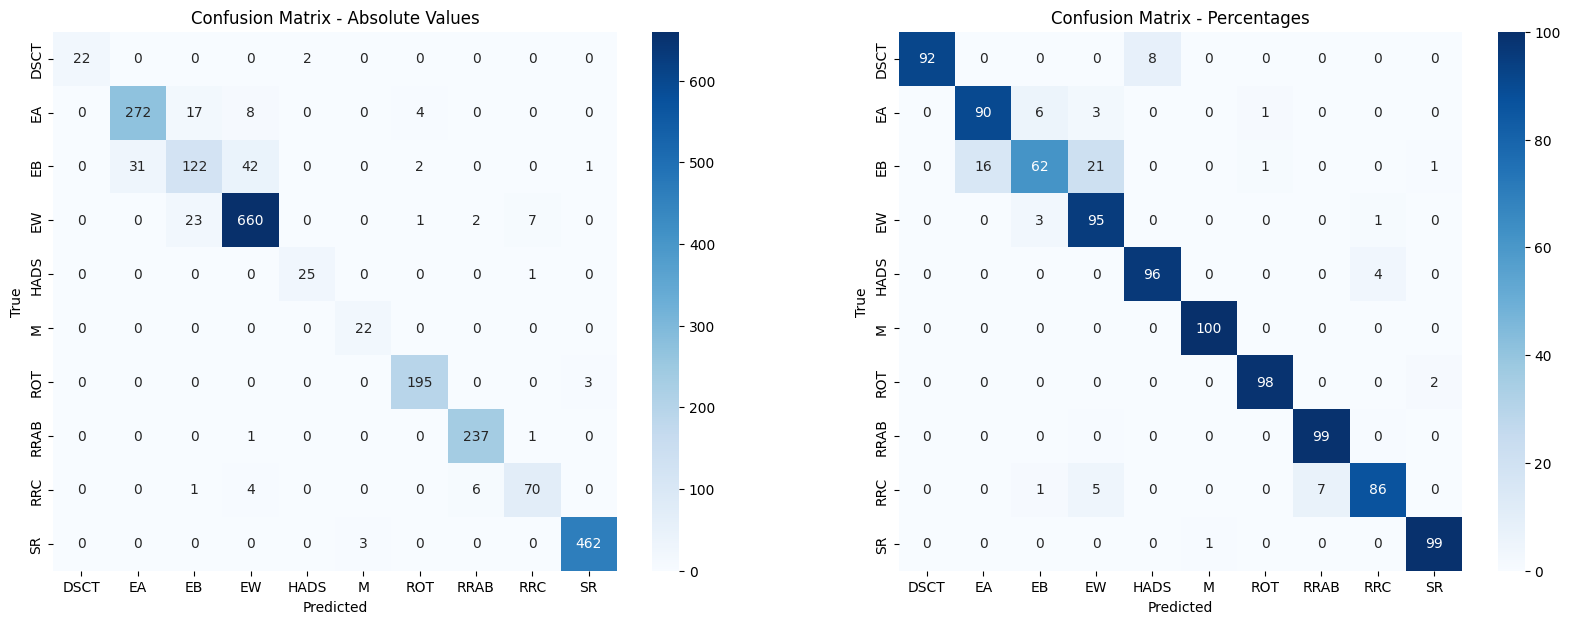

In [71]:
evaluate(model4, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:24<00:00,  2.87it/s]


Total Accuracy: 91.05%
Avarage Accuracy: 89.9%


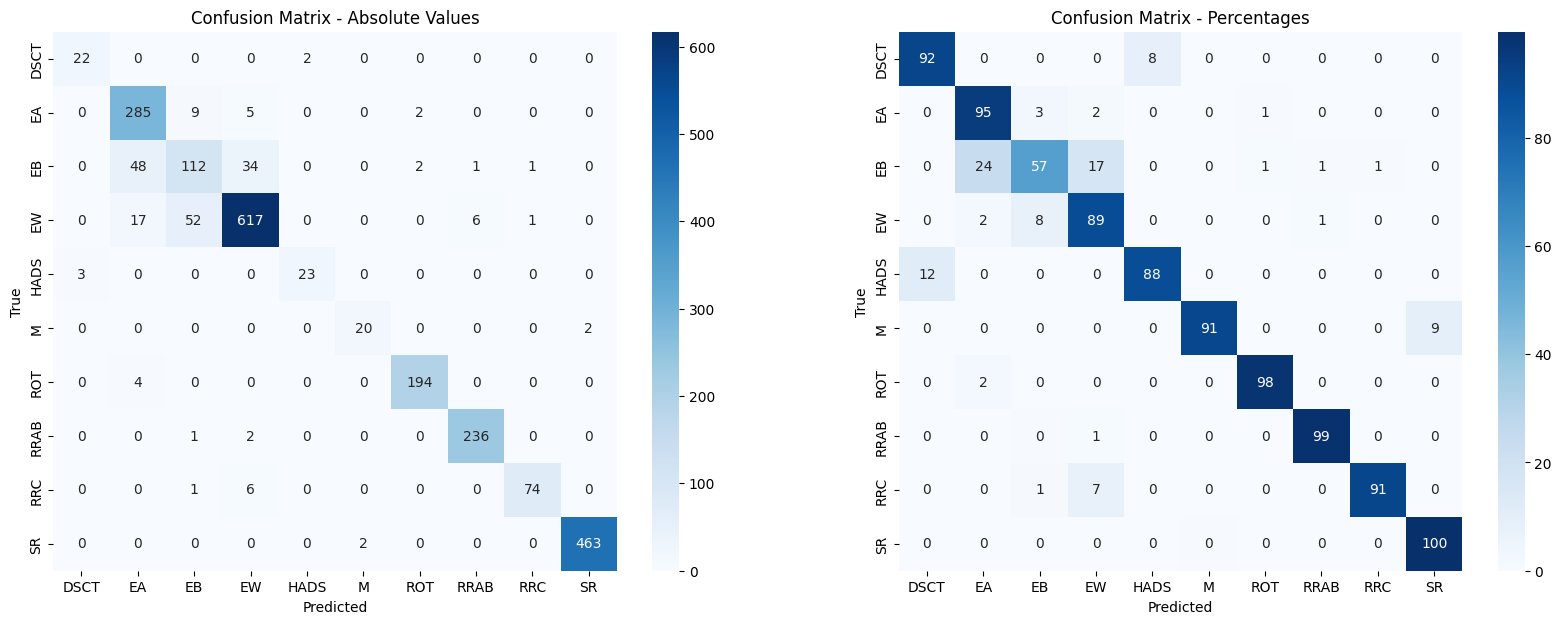

In [72]:
evaluate(model5, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:24<00:00,  2.95it/s]


Total Accuracy: 94.08%
Avarage Accuracy: 92.67%


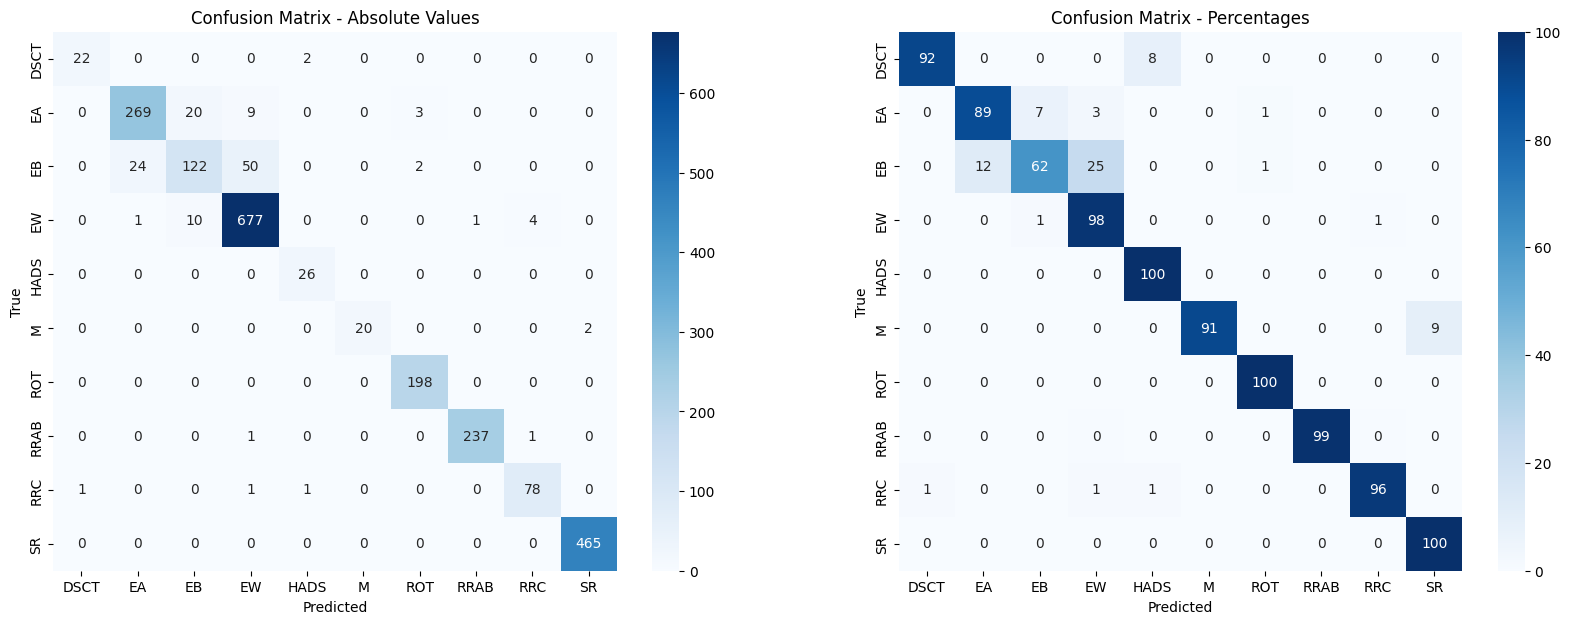

In [73]:
evaluate(model6, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:23<00:00,  2.98it/s]


Total Accuracy: 94.26%
Avarage Accuracy: 93.02%


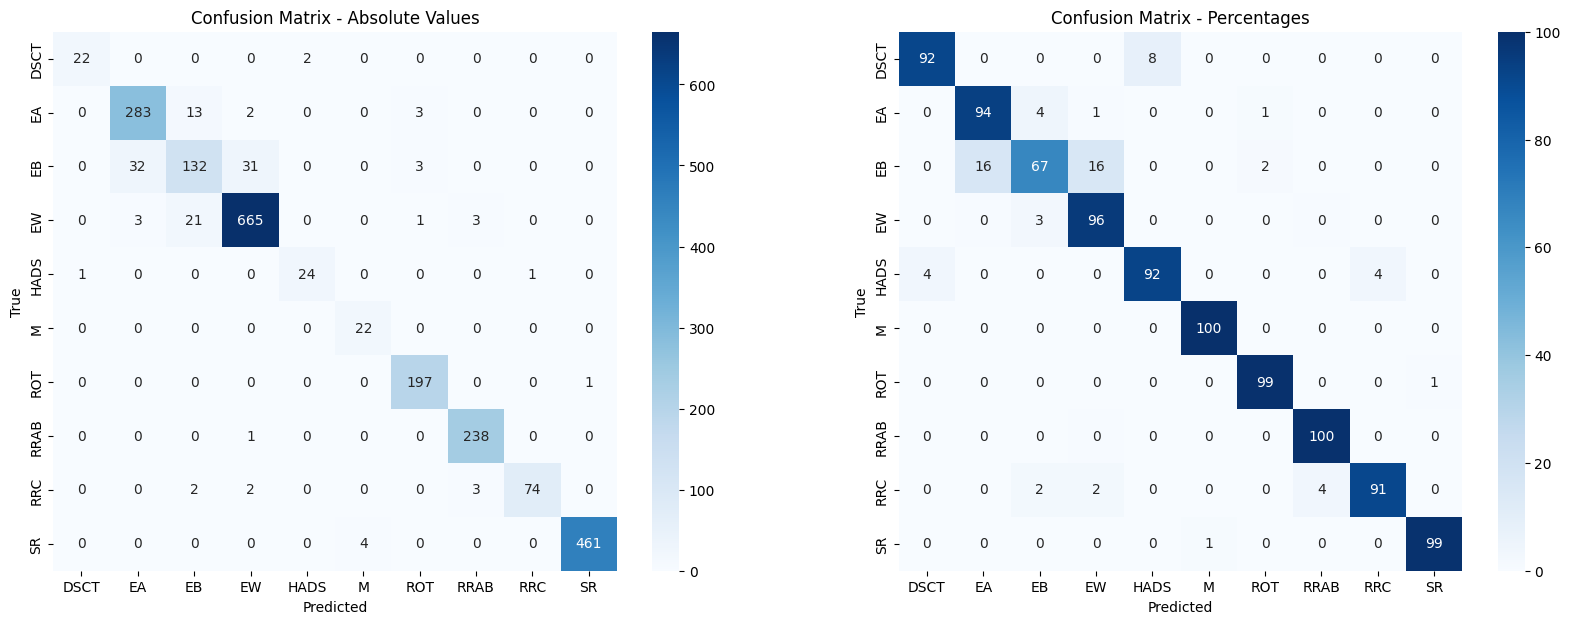

In [74]:
evaluate(model7, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:27<00:00,  2.62it/s]


Total Accuracy: 90.61%
Avarage Accuracy: 89.75%


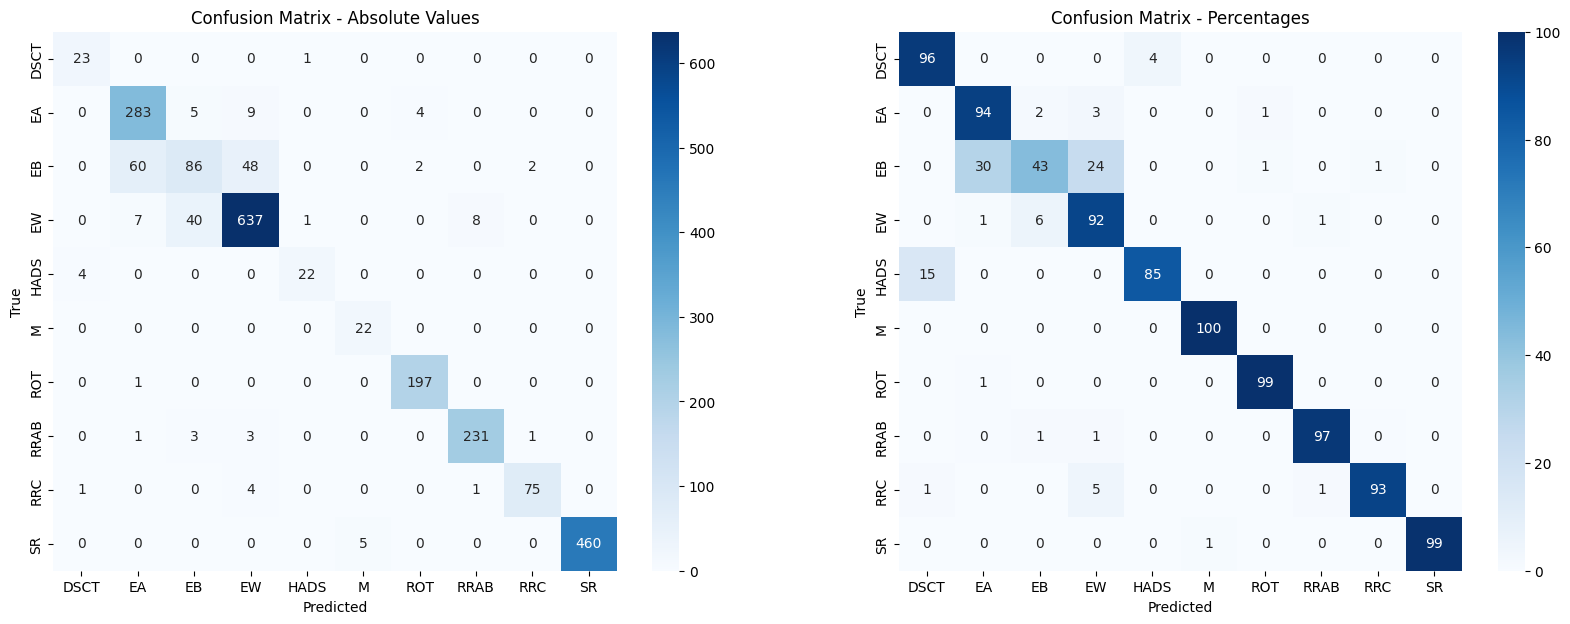

In [84]:
evaluate(model8, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:23<00:00,  2.99it/s]


Total Accuracy: 93.59%
Avarage Accuracy: 91.47%


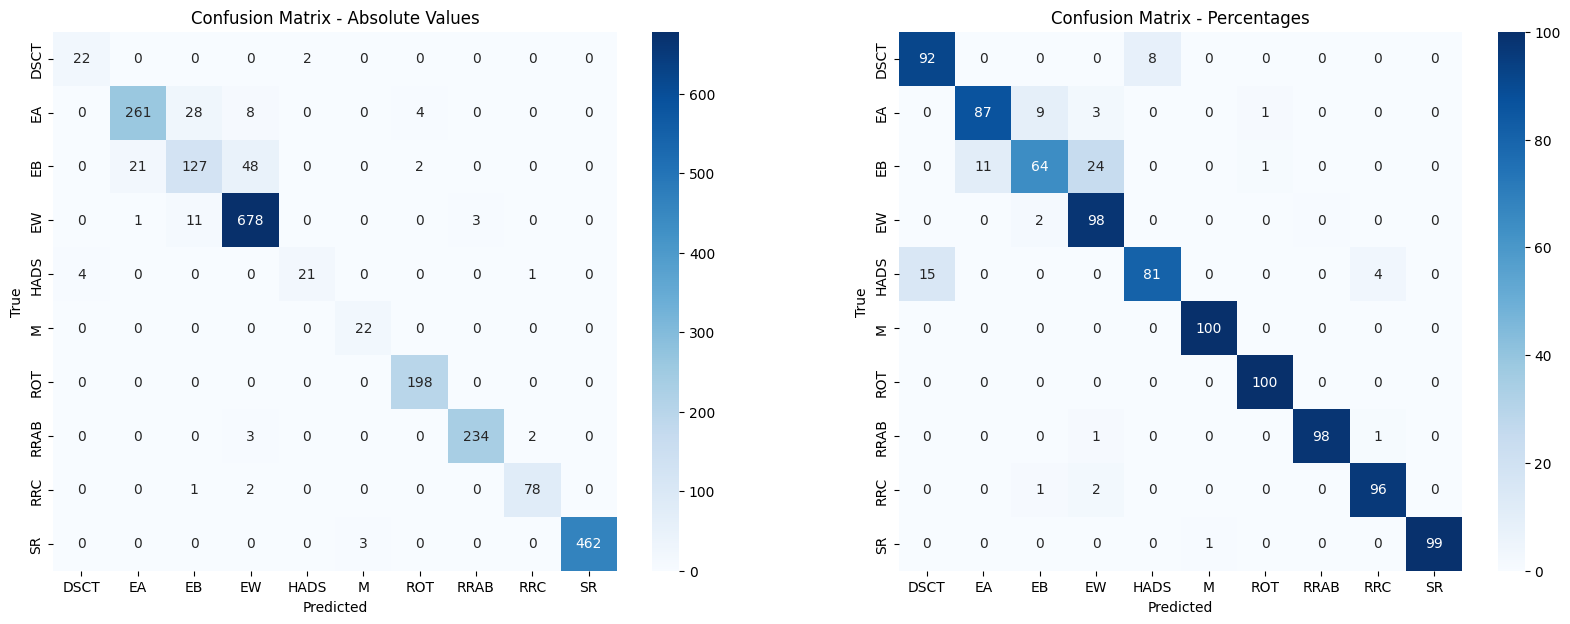

In [85]:
evaluate(model9, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:23<00:00,  2.99it/s]


Total Accuracy: 94.3%
Avarage Accuracy: 93.61%


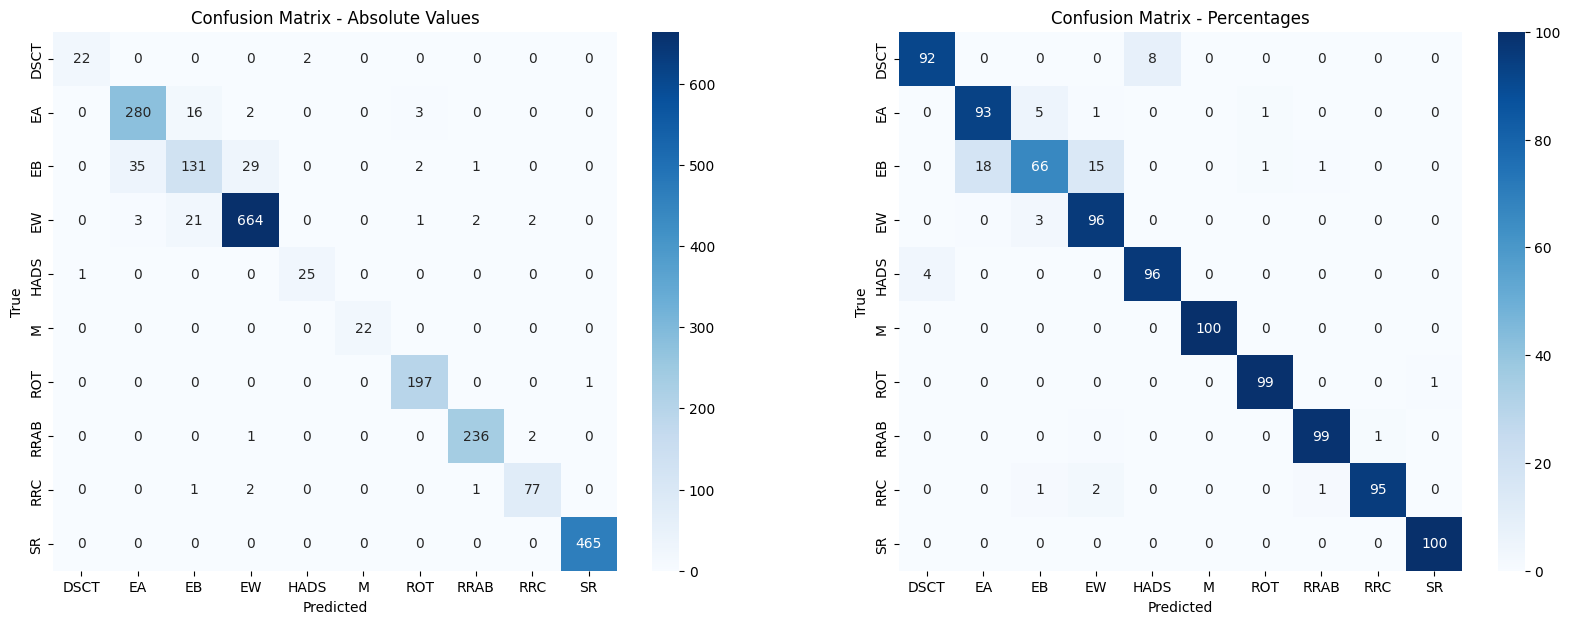

In [86]:
evaluate(model10, test_dataloader)

In [85]:
model = ClassificationModelv0(config, train_dataset.num_classes, freeze=False, 
                              weights_path='/home/mariia/AstroML/weights/2024-06-13-18-41-lwvpa5fm/weights-49.pth')
model = model.to(device)
optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
criterion = nn.CrossEntropyLoss()

In [89]:
for i in range(10):
    print(f'Epoch {i}')
    train_epoch()
    val_epoch()

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.52it/s]


Train Loss: 0.5931056897397394, 0.8333429811866859


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.28it/s]


Val Loss: 0.3330721323077074, 0.8951724137931034
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.32it/s]


Train Loss: 0.31245764807142595, 0.8968451519536903


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.50it/s]


Val Loss: 0.29241454486242113, 0.9002298850574713
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.46it/s]


Train Loss: 0.3020917903355978, 0.8973661360347323


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


Val Loss: 0.29845380770754726, 0.8974712643678161
Epoch 3


  9%|███████▍                                                                        | 50/540 [00:05<00:58,  8.39it/s]


KeyboardInterrupt: 

In [86]:
optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
criterion = nn.CrossEntropyLoss()

In [74]:
for i in range(10):
    print(f'Epoch {i}')
    train_epoch()
    val_epoch()

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:05<00:00,  8.21it/s]


Train Loss: 2.192672982039275, 0.6531403762662807


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


Val Loss: 2.179896666723139, 0.7935632183908046
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.32it/s]


Train Loss: 2.1779036676442183, 0.7906222865412446


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:31<00:00,  2.19it/s]


Val Loss: 2.1760356110685013, 0.7866666666666666
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.52it/s]


Train Loss: 2.1750995220961395, 0.8235021707670044


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.44it/s]


Val Loss: 2.1740241857136, 0.8188505747126437
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.53it/s]


Train Loss: 2.173926745520698, 0.8338639652677279


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]


Val Loss: 2.172785601195167, 0.8464367816091954
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.50it/s]


Train Loss: 2.1727485926062973, 0.8413892908827786


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.25it/s]


Val Loss: 2.173200586262871, 0.8505747126436781
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.37it/s]


Train Loss: 2.172336701993589, 0.8419681620839363


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.50it/s]


Val Loss: 2.1722547446980194, 0.8395402298850575
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:05<00:00,  8.21it/s]


Train Loss: 2.171693808502621, 0.8475253256150507


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


Val Loss: 2.172002175275017, 0.8372413793103448
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.42it/s]


Train Loss: 2.1714963255105197, 0.8472358900144717


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.43it/s]


Val Loss: 2.172502703526441, 0.8294252873563218
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:06<00:00,  8.12it/s]


Train Loss: 2.1710141742670976, 0.8512301013024602


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.24it/s]


Val Loss: 2.1714599623399624, 0.8422988505747127
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:07<00:00,  8.05it/s]


Train Loss: 2.1705865851155033, 0.8529667149059335


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.23it/s]

Val Loss: 2.171125583788928, 0.8468965517241379


In [39]:
train_epoch()

100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.58it/s]

Train Loss: 1.662082983608599, 0.8527351664254703


In [40]:
val_epoch()

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.23it/s]

Val Loss: 1.5936207508339602, 0.9094252873563219


In [41]:
for i in range(1, 10):
    print(f'Epoch {i}')
    train_epoch()

Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.56it/s]


Train Loss: 1.5804842346244388, 0.9176266280752533


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.32it/s]


Val Loss: 1.5769630442647373, 0.9075862068965517
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.58it/s]


Train Loss: 1.56808623958517, 0.9230101302460203


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


Val Loss: 1.5689235539997326, 0.9245977011494253
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:05<00:00,  8.30it/s]


Train Loss: 1.5611879737288863, 0.9256150506512301


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:26<00:00,  2.53it/s]


Val Loss: 1.5678219707573162, 0.9167816091954023
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:06<00:00,  8.14it/s]


Train Loss: 1.5569490112640239, 0.9301881331403763


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.25it/s]


Val Loss: 1.5697140465764439, 0.9052873563218391
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:05<00:00,  8.24it/s]


Train Loss: 1.5530220303270552, 0.9312301013024602


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.40it/s]


Val Loss: 1.557156189399607, 0.9222988505747126
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.31it/s]


Train Loss: 1.549370076921251, 0.9348191027496382


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.36it/s]


Val Loss: 1.5560079918188208, 0.926896551724138
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.44it/s]


Train Loss: 1.5467209370047958, 0.9347033285094066


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


Val Loss: 1.5541838091962479, 0.9347126436781609
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.32it/s]


Train Loss: 1.5435211755611278, 0.9378871201157742


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.43it/s]


Val Loss: 1.5582327071358175, 0.9204597701149425
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.52it/s]


Train Loss: 1.5447637858214203, 0.9368451519536903


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.28it/s]

Val Loss: 1.5606914951520807, 0.9181609195402299


In [53]:
for i in range(10, 50):
    print(f'Epoch {i}')
    train_epoch()
    val_epoch()

Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.69it/s]


Train Loss: 1.5395311415195465, 0.9399710564399422


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.28it/s]


Val Loss: 1.5533593086635364, 0.9250574712643678
Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.44it/s]


Train Loss: 1.5391578990000265, 0.9404341534008683


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]


Val Loss: 1.5533499191789066, 0.9259770114942528
Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.52it/s]


Train Loss: 1.5366818233772561, 0.9411287988422576


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.38it/s]


Val Loss: 1.5523033755667068, 0.9264367816091954
Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.63it/s]


Train Loss: 1.534952031020765, 0.94205499276411


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.49it/s]


Val Loss: 1.5548599204596352, 0.927816091954023
Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.61it/s]


Train Loss: 1.5328811559412214, 0.9457018813314038


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.42it/s]


Val Loss: 1.5554732382297516, 0.9282758620689655
Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.57it/s]


Train Loss: 1.531165321667989, 0.945412445730825


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.41it/s]


Val Loss: 1.5565247693482567, 0.926896551724138
Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.38it/s]


Train Loss: 1.5304509182771047, 0.9477858176555717


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:32<00:00,  2.06it/s]


Val Loss: 1.5522888653418596, 0.9282758620689655
Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:06<00:00,  8.15it/s]


Train Loss: 1.5292822473578982, 0.9468596237337192


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]


Val Loss: 1.5536175598116482, 0.9222988505747126
Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.52it/s]


Train Loss: 1.5275298151705, 0.948712011577424


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.32it/s]


Val Loss: 1.5564120920265423, 0.9213793103448276
Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.47it/s]


Train Loss: 1.527084888352288, 0.9481331403762663


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]


Val Loss: 1.5509927833781523, 0.9282758620689655
Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:02<00:00,  8.60it/s]


Train Loss: 1.5281127320395576, 0.9470332850940666


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.43it/s]


Val Loss: 1.5542087625054752, 0.9218390804597701
Epoch 21


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.37it/s]


Train Loss: 1.5250719008622347, 0.9488856729377714


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.43it/s]


Val Loss: 1.5485269953222836, 0.9319540229885057
Epoch 22


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.53it/s]


Train Loss: 1.523015405955138, 0.9508538350217076


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.40it/s]


Val Loss: 1.5512112887466656, 0.9264367816091954
Epoch 23


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:06<00:00,  8.14it/s]


Train Loss: 1.5217540460604209, 0.9508538350217076


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.37it/s]


Val Loss: 1.5491555806468515, 0.9347126436781609
Epoch 24


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.42it/s]


Train Loss: 1.5224556465943655, 0.9513169319826339


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]


Val Loss: 1.5535302845870747, 0.92
Epoch 25


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:03<00:00,  8.47it/s]


Train Loss: 1.5221896021454422, 0.9507959479015919


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.29it/s]


Val Loss: 1.549266080645954, 0.927816091954023
Epoch 26


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [01:04<00:00,  8.32it/s]


Train Loss: 1.5218135648303561, 0.952821997105644


100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]


Val Loss: 1.5595893649493946, 0.92
Epoch 27


  2%|█▋                                                                              | 11/540 [00:02<02:09,  4.08it/s]


KeyboardInterrupt: 

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.43it/s]


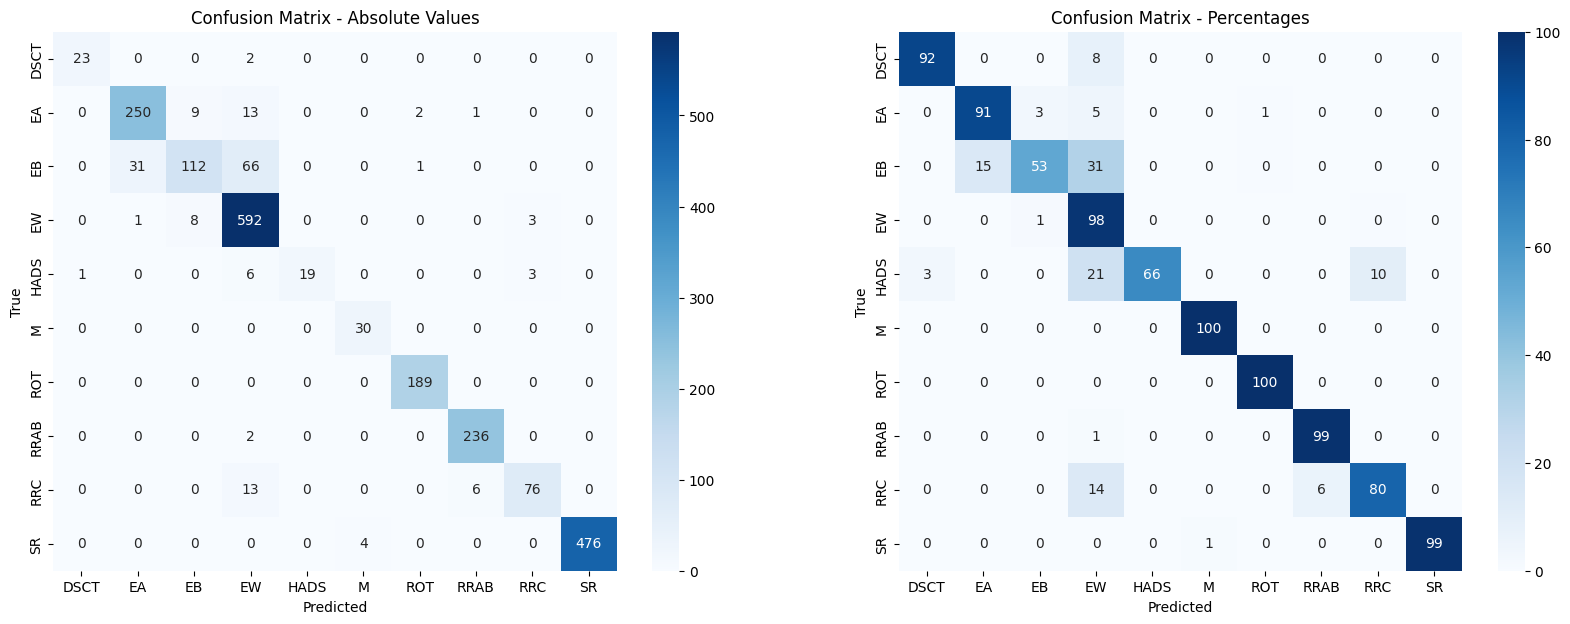

In [45]:
evaluate()